In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn import model_selection
from sklearn.metrics import roc_auc_score

In [3]:
train = pd.read_csv('example/data/train.csv')
val = pd.read_csv('example/data/jessie/val.csv')

In [4]:
val2 = val.drop(['click'],axis = 1)

In [5]:
def adaboost(x,y, t, s,split, l=1 ): 
    
    seed = s
    num_trees = t
    kfold = model_selection.KFold(n_splits=split, random_state=seed)
    model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed, learning_rate= l)
    #results = model_selection.cross_val_score(model, x, y, cv=kfold)
    
    model.fit(x,y)
    #probability_train=[]
    #probability_test=[]
    #probability_train.append(model.predict_proba(x))
    #probability_test.append(model.predict_proba(val2))
    print(roc_auc_score(val['click'], model.predict_proba(val2)[:,1]))
    val['target'] = model.predict_proba(val2)[:,1]
    #print(probability_test)
    #print(results.mean())
    return val

In [6]:
y = np.ravel(train[['click']])
x = train.drop(columns = ['click'])

In [7]:
val_pp = pd.read_csv('validation.csv')

In [8]:
val_pctr = adaboost(x,y,50,42,150)

0.7482717609776208


In [9]:
val_pctr['bidprice'] = val_pp['bidprice']
val_pctr['payprice'] = val_pp['payprice']

In [10]:
val_pctr.head()

,click,weekday,hour,region,city,adexchange,slotwidth,slotheight,slotprice,advertiser,...,browser_ie,browser_maxthon,browser_opera,browser_other,browser_safari,browser_sogou,browser_theworld,target,bidprice,payprice
0,0,4,20,79,79,1,160,600,0,1458,...,1,0,0,0,0,0,0,0.473492,300,23
1,0,1,21,79,79,1,950,90,0,3476,...,0,0,0,0,0,0,0,0.470503,238,75
2,0,4,8,2,2,2,300,250,5,3358,...,1,0,0,0,0,0,0,0.471818,238,65
3,0,5,15,201,205,2,336,280,5,3358,...,0,0,0,0,0,0,0,0.469955,238,6
4,0,1,18,134,135,2,200,200,5,3476,...,0,0,0,0,0,0,0,0.472446,249,5


In [10]:
val_pctr.to_csv('val_adaboost.csv')

# Linear bidding

In [11]:
avg_ctr = np.mean(val_pctr['click'])

In [12]:
def ad1_spend(x,df):
    clicks=0
    budget=6250000
    #avg_ctr=df3['click'].sum()/len(df3)
    df['bid']=x*df['target']/avg_ctr
    for i in range(len(df)):
        #print(i)
        y = df['payprice'].iloc[i]
        b=df['bid'].iloc[i]
        if budget <= y:
            break
        if (b>=y and b >=df['slotprice'].iloc[i]):
            budget -= df['payprice'].iloc[i]
            clicks += df['click'].iloc[i]
    spend = 6250000-budget
    return clicks,spend

In [20]:
sp3_tr=[]
c3_tr=[]
ad3=val_pctr.copy()
range_bid_base=np.arange(0.12,0.14,0.005)
for bid_base in range_bid_base:
    print(bid_base)
    a, b = ad1_spend(bid_base,ad3)
    c3_tr.append(a)
    sp3_tr.append(b)
    print('clicks:',a)
    print('spend:',b)
print(sp3_tr)
print(c3_tr)

0.12
clicks: 67
spend: 6249786
0.125
clicks: 68
spend: 6249904
0.13
clicks: 66
spend: 6249972
0.135
clicks: 66
spend: 6249904
0.14
clicks: 63
spend: 6249994
[6249786, 6249904, 6249972, 6249904, 6249994]
[67, 68, 66, 66, 63]


In [49]:
import matplotlib.pyplot as plt

In [50]:
ab_lin = pd.DataFrame({'base_bid': range_bid_base,'clicks': c3_tr})
ab_lin = ab_lin.set_index('base_bid')

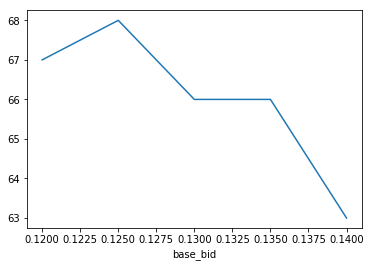

In [51]:
#dfm_lin = pd.DataFrame({'base_bid': range_bid_base,'clicks': c3_tr})
ab_lin['clicks'].plot()
plt.show()

# Range based bidding

In [54]:
train_one = val_pctr[val_pctr['click']==1]

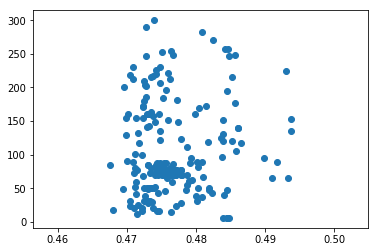

In [55]:
import matplotlib.pyplot as plt
x = train_one['target']
y = train_one['payprice']
plt.scatter(x, y)
plt.show()

In [56]:
for i in np.arange(0.47,0.473,0.0005):
    train_two =train_one[train_one['target']>i]
    a = np.sort(train_two[train_two['target']<= i + 0.0005].reset_index()['payprice'])
    #print(a)
    if (len(a) == 0):
        continue
    elif (len(a) <= 2):
        print(i, '-', i+0.0005, ":", "0.8", ":", a[len(a)-1])
    else:
        print(i, '-', i+0.0005, ":", "0.8", ":", a[round(len(a)*0.8)])

for i in np.arange(0.473,0.474,0.0001):
    train_two =train_one[train_one['target']>i]
    a = np.sort(train_two[train_two['target']<= i + 0.0001].reset_index()['payprice'])
    #print(a)
    if (len(a) == 0):
        continue
    else:
        print(i, '-', i+0.0001, ":", "1.0", ":", a[len(a)-1])
        
for i in np.arange(0.475,0.48,0.0005):
    train_two =train_one[train_one['target']>i]
    a = np.sort(train_two[train_two['target']<= i + 0.0005].reset_index()['payprice'])
    if (len(a) == 0):
        continue
    else:
        print(i, '-', i+0.0005, ":", "1.0", ":", a[len(a)-1])

for i in np.arange(0.48,0.50,0.005):
    train_two =train_one[train_one['target']>i]
    a = np.sort(train_two[train_two['target']<= i + 0.005].reset_index()['payprice'])
    #print(a)
    if (len(a) == 0):
        continue
    else:
        print(i, '-', i+0.005, ":", "1.0", ":", a[len(a)-1])

0.47 - 0.4705 : 0.8 : 218
0.4705 - 0.471 : 0.8 : 231
0.471 - 0.4715 : 0.8 : 101
0.4715 - 0.472 : 0.8 : 133
0.472 - 0.4725 : 0.8 : 172
0.4725 - 0.473 : 0.8 : 247
0.473 - 0.4735 : 0.8 : 142
0.473 - 0.47309999999999997 : 1.0 : 84
0.47309999999999997 - 0.47319999999999995 : 1.0 : 50
0.47319999999999995 - 0.47329999999999994 : 1.0 : 160
0.47329999999999994 - 0.47339999999999993 : 1.0 : 31
0.47339999999999993 - 0.4734999999999999 : 1.0 : 80
0.4734999999999999 - 0.4735999999999999 : 1.0 : 215
0.4735999999999999 - 0.4736999999999999 : 1.0 : 30
0.4736999999999999 - 0.4737999999999999 : 1.0 : 217
0.4737999999999999 - 0.4738999999999999 : 1.0 : 300
0.4738999999999999 - 0.47399999999999987 : 1.0 : 50
0.47399999999999987 - 0.47409999999999985 : 1.0 : 73
0.475 - 0.4755 : 1.0 : 253
0.4755 - 0.476 : 1.0 : 221
0.476 - 0.4765 : 1.0 : 254
0.4765 - 0.477 : 1.0 : 248
0.477 - 0.4775 : 1.0 : 182
0.4775 - 0.478 : 1.0 : 124
0.4785 - 0.479 : 1.0 : 112
0.479 - 0.4795 : 1.0 : 95
0.4795 - 0.48 : 1.0 : 160
0.48 - 0

In [60]:

def fill_bid(x,target):
    val['bid']=""
    bid = 0
    if (target > 0.49):
        bid = 230
    elif (target >= 0.485):
        bid = 250
    elif (target >= 0.48):
        bid= 285
    elif (target >= 0.4795):
        bid = 161
    elif (target >= 0.479):
        bid = 96
    #elif (target >= 0.019):
       # bid = 55
    elif (target >= 0.4785):
        bid = 115
    #elif (target >= 0.017):
     #   bid = 120
    elif (target >= 0.4775):
        bid = 125
    elif (target >= 0.477):
        bid = 185
    elif (target >= 0.4765):
        bid = 250
    elif (target >= 0.476):
        bid = 255
   # elif (target >= 0.012):
     #   bid = 125
    elif (target >= 0.4755):
        bid = 225
    elif (target >= 0.475):
        bid = 255
    elif (target >= x): #0.473
        bid = 75 #220 - 94 #150 -99 100-107 80-114 50-121 75-127
   # elif (target >= x): #0.473
    #    bid = 75
    else:
        bid = 0
    return bid

In [61]:
def final_spend(df):
    clicks=0
    budget=6250000
    for i in range(len(df)):
        y = df['payprice'].iloc[i]
        b=df['bid'].iloc[i]
        if budget <= y:
            print("cutoff "+ str(i))
            break
        if (b>=y and b >=df['slotprice'].iloc[i]):
            budget -= df['payprice'].iloc[i]
            clicks += df['click'].iloc[i]
    spend = 6250000-budget
    print(clicks)
    print(spend)
    return clicks

In [70]:
range_cut = np.arange(0.472,0.474,0.0005)
y = []
for r in range_cut:
    print(r)
    val['bid'] = val.apply(lambda row: fill_bid(r, row['target']), axis=1)
    y.append(final_spend(val))

0.472
cutoff 263302
110
6249877
0.4725
cutoff 282639
113
6249976
0.473
120
5838377
0.474
115
5495375


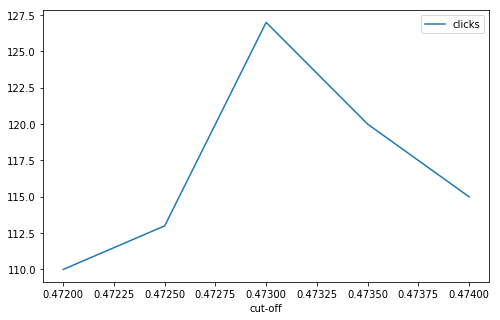

In [75]:
ab_rbb = pd.DataFrame({'cut-off': range_cut,'clicks': y})
ab_rbb = ab_rbb.set_index('cut-off')
ab_rbb.plot(figsize=(8,5))
plt.show()